# Getting Started
 - Shows collision detection
 - Provides a plotting function
 - Creates a slightly optimized submission

In [1]:
import shapely
print(f'Using shapely {shapely.__version__}')

Using shapely 2.1.2


In [2]:
import math
import os
import random
from decimal import Decimal, getcontext

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from shapely import affinity, touches
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree

pd.set_option('display.float_format', '{:.12f}'.format)

# Set precision for Decimal
getcontext().prec = 25
scale_factor = Decimal('1e15')

In [3]:
# Build the index of the submission, in the format:
#  <trees_in_problem>_<tree_index>

index = [f'{n:03d}_{t}' for n in range(1, 201) for t in range(n)]

In [4]:
class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x='0', center_y='0', angle='0'):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

In [5]:
def generate_weighted_angle():
    """
    Generates a random angle with a distribution weighted by abs(sin(2*angle)).
    This helps place more trees in corners, and makes the packing less round.
    """
    while True:
        angle = random.uniform(0, 2 * math.pi)
        if random.uniform(0, 1) < abs(math.sin(2 * angle)):
            return angle

In [6]:
def initialize_trees(num_trees, existing_trees=None):
    """
    This builds a simple, greedy starting configuration, by using the previous n-tree
    placements, and adding more tree for the (n+1)-tree configuration. We place a tree
    fairly far away at a (weighted) random angle, and the bring it closer to the center
    until it overlaps. Then we back it up until it no longer overlaps.

    You can easily modify this code to build each n-tree configuration completely
    from scratch.
    """
    if num_trees == 0:
        return [], Decimal('0')

    if existing_trees is None:
        placed_trees = []
    else:
        placed_trees = list(existing_trees)

    num_to_add = num_trees - len(placed_trees)

    if num_to_add > 0:
        unplaced_trees = [
            ChristmasTree(angle=random.uniform(0, 360)) for _ in range(num_to_add)]
        if not placed_trees:  # Only place the first tree at origin if starting from scratch
            placed_trees.append(unplaced_trees.pop(0))

        for tree_to_place in unplaced_trees:
            placed_polygons = [p.polygon for p in placed_trees]
            tree_index = STRtree(placed_polygons)

            best_px = None
            best_py = None
            min_radius = Decimal('Infinity')

            # This loop tries 10 random starting attempts and keeps the best one
            for _ in range(10):
                # The new tree starts at a position 20 from the center, at a random vector angle.
                angle = generate_weighted_angle()
                vx = Decimal(str(math.cos(angle)))
                vy = Decimal(str(math.sin(angle)))

                # Move towards center along the vector in steps of 0.5 until collision
                radius = Decimal('20.0')
                step_in = Decimal('0.5')

                collision_found = False
                while radius >= 0:
                    px = radius * vx
                    py = radius * vy

                    candidate_poly = affinity.translate(
                        tree_to_place.polygon,
                        xoff=float(px * scale_factor),
                        yoff=float(py * scale_factor))

                    # Looking for nearby objects
                    possible_indices = tree_index.query(candidate_poly)
                    # This is the collision detection step
                    if any((candidate_poly.intersects(placed_polygons[i]) and not
                            candidate_poly.touches(placed_polygons[i]))
                           for i in possible_indices):
                        collision_found = True
                        break
                    radius -= step_in

                # back up in steps of 0.05 until it no longer has a collision.
                if collision_found:
                    step_out = Decimal('0.05')
                    while True:
                        radius += step_out
                        px = radius * vx
                        py = radius * vy

                        candidate_poly = affinity.translate(
                            tree_to_place.polygon,
                            xoff=float(px * scale_factor),
                            yoff=float(py * scale_factor))

                        possible_indices = tree_index.query(candidate_poly)
                        if not any((candidate_poly.intersects(placed_polygons[i]) and not
                                   candidate_poly.touches(placed_polygons[i]))
                                   for i in possible_indices):
                            break
                else:
                    # No collision found even at the center. Place it at the center.
                    radius = Decimal('0')
                    px = Decimal('0')
                    py = Decimal('0')

                if radius < min_radius:
                    min_radius = radius
                    best_px = px
                    best_py = py

            tree_to_place.center_x = best_px
            tree_to_place.center_y = best_py
            tree_to_place.polygon = affinity.translate(
                tree_to_place.polygon,
                xoff=float(tree_to_place.center_x * scale_factor),
                yoff=float(tree_to_place.center_y * scale_factor),
            )
            placed_trees.append(tree_to_place)  # Add the newly placed tree to the list

    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds

    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor

    width = maxx - minx
    height = maxy - miny
    # this forces a square bounding using the largest side
    side_length = max(width, height)

    return placed_trees, side_length

In [8]:
def plot_results(side_length, placed_trees, num_trees):
    """Plots the arrangement of trees and the bounding square."""
    _, ax = plt.subplots(figsize=(6, 6))
    colors = plt.cm.viridis([i / num_trees for i in range(num_trees)])

    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds

    for i, tree in enumerate(placed_trees):
        # Rescale for plotting
        x_scaled, y_scaled = tree.polygon.exterior.xy
        x = [Decimal(val) / scale_factor for val in x_scaled]
        y = [Decimal(val) / scale_factor for val in y_scaled]
        ax.plot(x, y, color=colors[i])
        ax.fill(x, y, alpha=0.5, color=colors[i])

    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor

    width = maxx - minx
    height = maxy - miny

    square_x = minx if width >= height else minx - (side_length - width) / 2
    square_y = miny if height >= width else miny - (side_length - height) / 2
    bounding_square = Rectangle(
        (float(square_x), float(square_y)),
        float(side_length),
        float(side_length),
        fill=False,
        edgecolor='red',
        linewidth=2,
        linestyle='--',
    )
    ax.add_patch(bounding_square)

    padding = 0.5
    ax.set_xlim(
        float(square_x - Decimal(str(padding))),
        float(square_x + side_length + Decimal(str(padding))))
    ax.set_ylim(float(square_y - Decimal(str(padding))),
                float(square_y + side_length + Decimal(str(padding))))
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    plt.title(f'{num_trees} Trees: {side_length:.12f}')
    plt.show()
    plt.close()

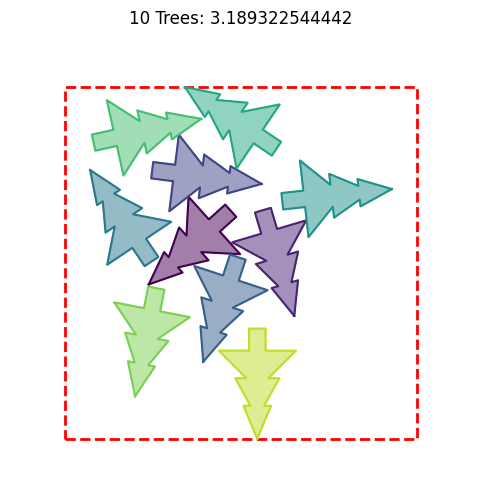

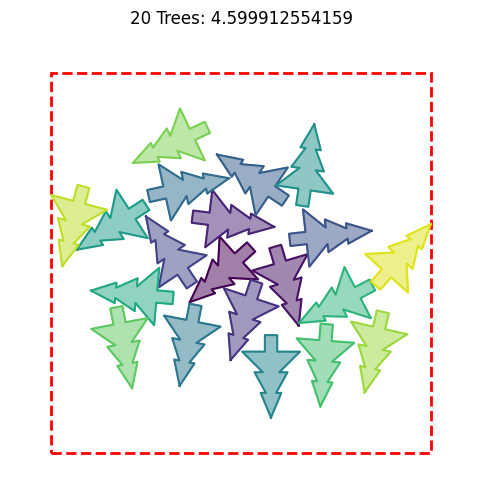

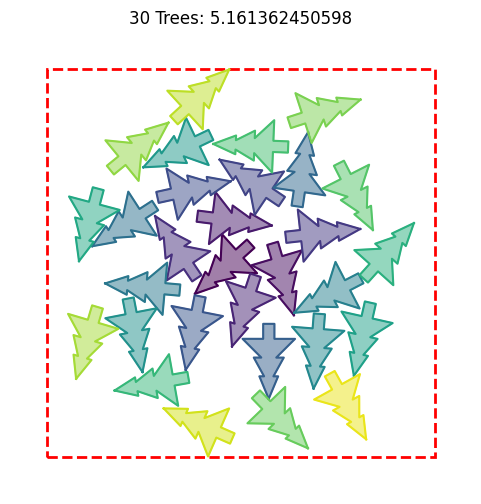

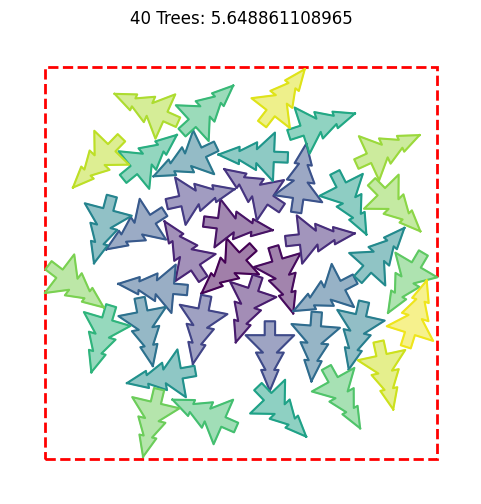

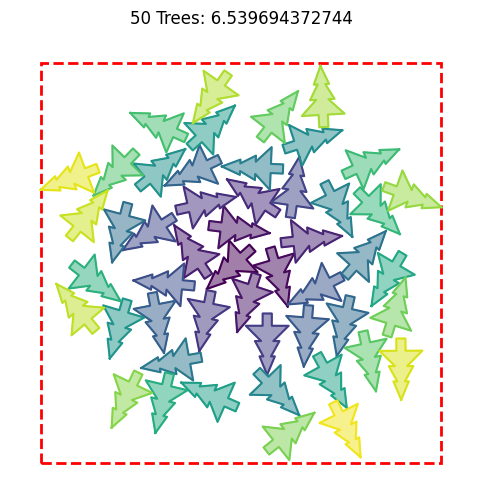

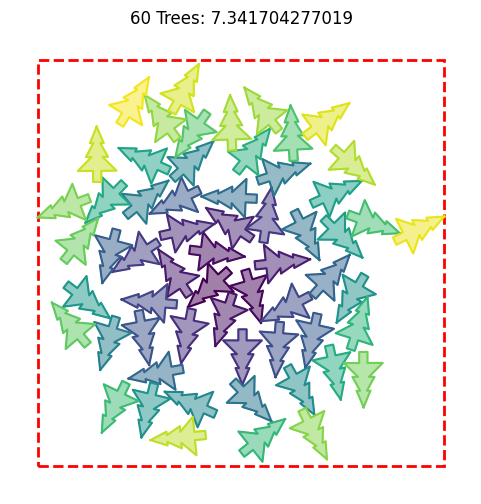

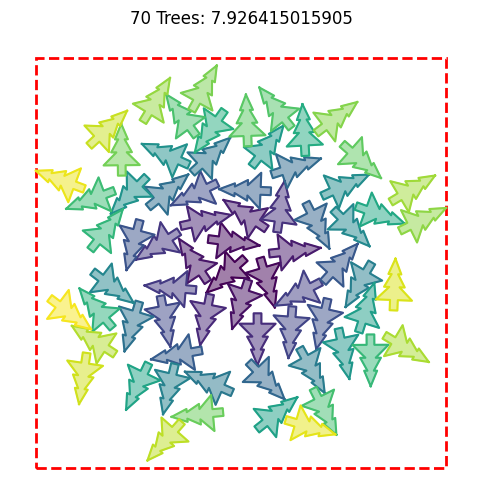

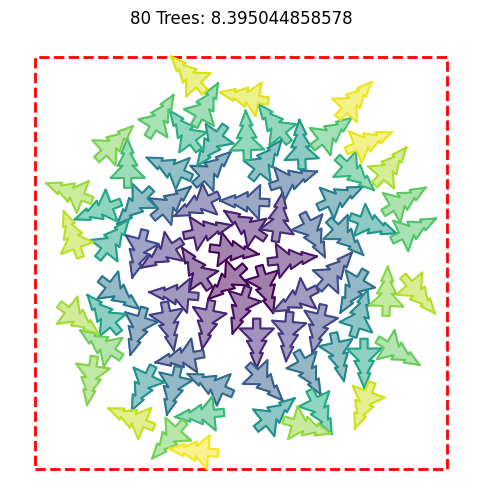

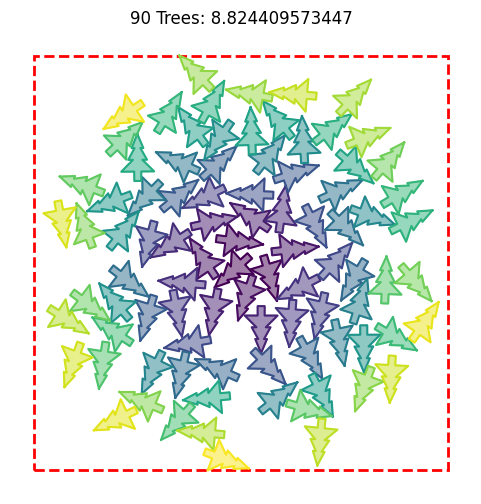

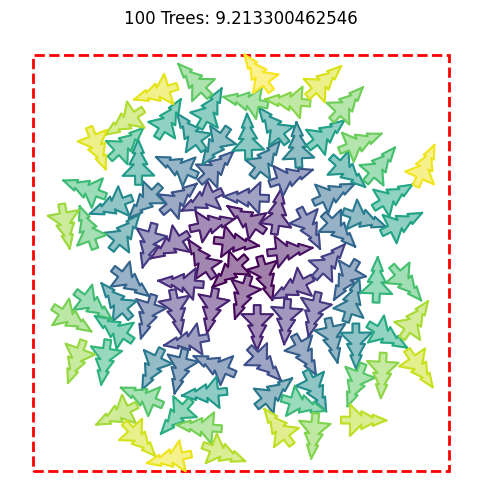

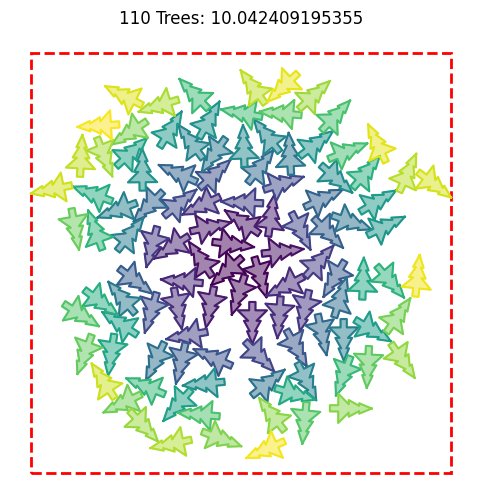

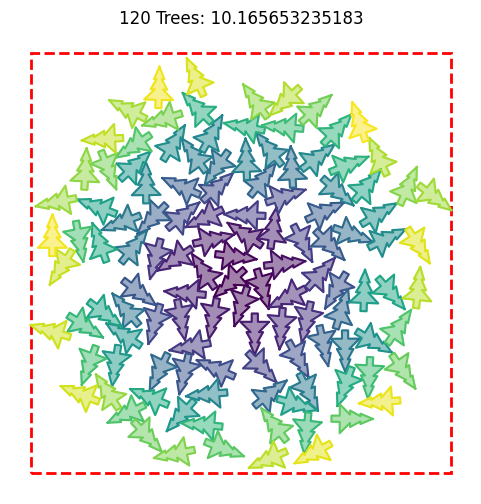

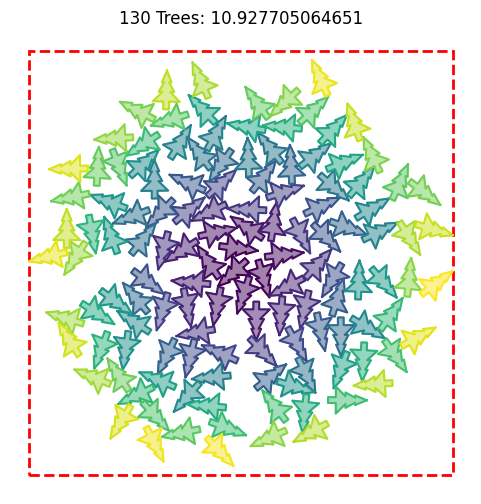

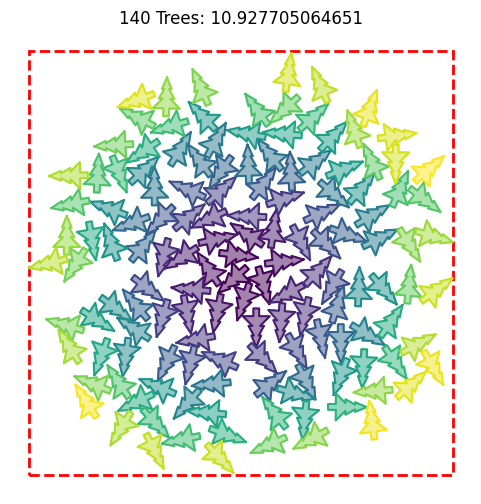

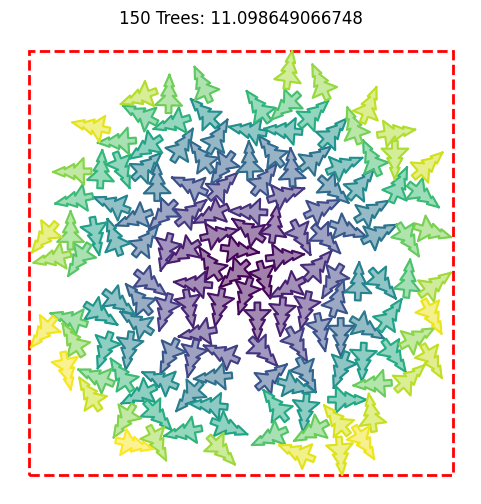

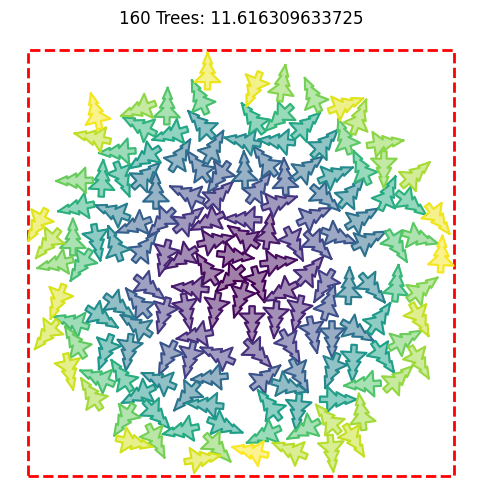

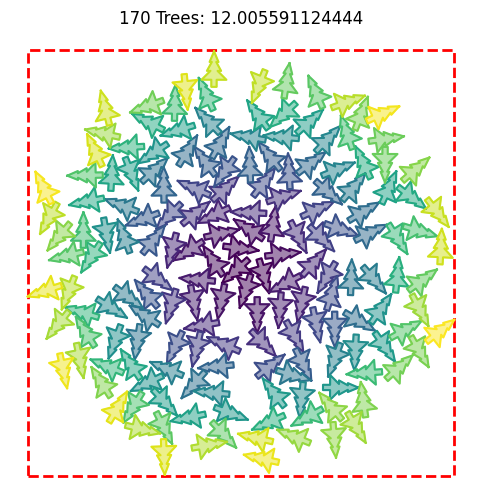

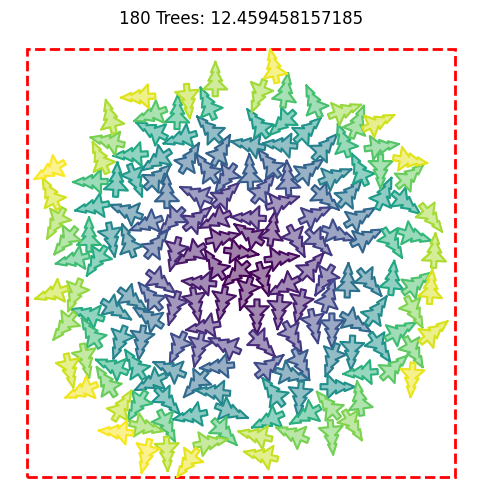

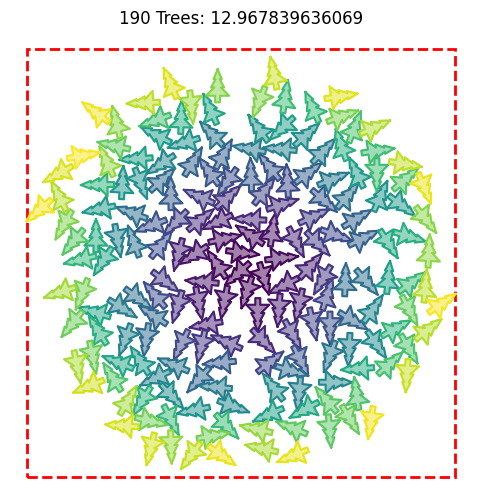

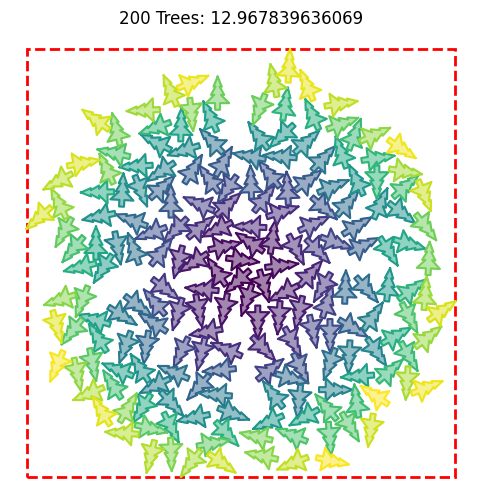

In [9]:
tree_data = []
current_placed_trees = []  # Initialize an empty list for the first iteration

for n in range(200):
    # Pass the current_placed_trees to initialize_trees
    current_placed_trees, side = initialize_trees(n+1, existing_trees=current_placed_trees)
    if (n+1) % 10 == 0:
        plot_results(side, current_placed_trees, n+1)
    for tree in current_placed_trees:
        tree_data.append([tree.center_x, tree.center_y, tree.angle])
        
cols = ['x', 'y', 'deg']
submission = pd.DataFrame(
    index=index, columns=cols, data=tree_data).rename_axis('id')

for col in cols:
    submission[col] = submission[col].astype(float).round(decimals=6)
    
# To ensure everything is kept as a string, prepend an 's'
for col in submission.columns:
    submission[col] = 's' + submission[col].astype('string')
submission.to_csv('sample_submission.csv')